Source: https://www.kaggle.com/ahassaine/pure-image-processing-lb-0-274/code 


# Libraries and Global Parameters 

In [106]:
import os
#import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.util import img_as_bool, img_as_uint, img_as_ubyte
from skimage.transform import resize
#import skimage
#import glob
import random
from random import randint #, shuffle

from keras import regularizers
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, Dense, \
    UpSampling2D, BatchNormalization, add, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.losses import binary_crossentropy

model_checkpoint_file='bw_model_v4.h5'

# Root folders for test and training data
train_root = "./stage1_train"
test_root = "./stage1_test"

# Size we resize all images to
#image_size = (128,128)

img_height = 64
img_width = 64

# Preparing the Data

In [28]:
## Import Training Data Images 
train_dirs = os.listdir(train_root)
train_filenames=[os.path.join(train_root,file_id) + "/images/"+file_id+".png" for file_id in train_dirs]
# Convert to B&W inline
#train_images=[cv2.cvtColor(cv2.imread(imagefile),cv2.COLOR_BGR2GRAY) for imagefile in train_filenames]
train_images=[imread(imagefile,as_grey=True) for imagefile in train_filenames]

# Use this instead if you want color images
#train_images=[imread(imagefile) for imagefile in train_filenames]


In [29]:
## Import Training Masks
# this takes longer than the training images because we have to
# combine a lot of mask files

# This function creates a single combined mask image 
# when given a list of masks
# Probably a computationally faster way to do this...
def collapse_masks(mask_list):
    for i, mask_file in enumerate(mask_list):        
        if i != 0:
            # combine mask with previous mask in list 
            mask = np.maximum(mask, imread(os.path.join(train_root,mask_file)))
        else:
            # read first mask in
            mask = imread(os.path.join(train_root,mask_file))
    
    return mask

# Import all the masks
train_mask_dirs = [ os.path.join(path, 'masks') for path in os.listdir(train_root) ]
train_mask_files = [ [os.path.join(dir,file) for file in os.listdir(os.path.join(train_root,dir)) ]  for dir in train_mask_dirs]

#def collapse_masks(mask_list):
#    for i, mask_file in enumerate(mask_list):
#        print(i)
#        print(mask_file)
        
#testing = [collapse_masks(mask_files) for mask_files in train_mask_files]

# Divide output of each mask by 255 to make a 1/0 binary mask
train_mask_images = [ collapse_masks(mask_files) for mask_files in train_mask_files ]


In [30]:
train_mask_images[0].max()

255

Image #: 20. Image Sizes: (256, 256) (256, 256)


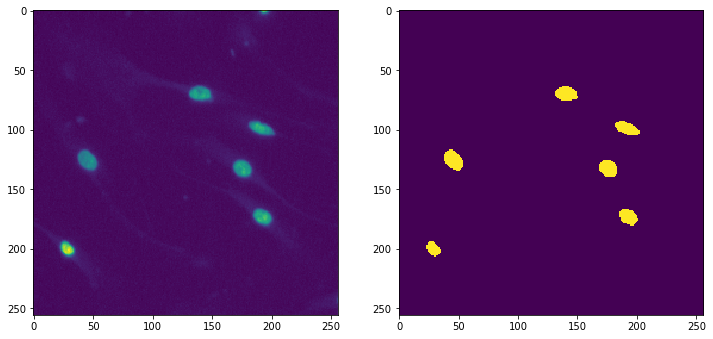

Image #: 57. Image Sizes: (360, 360) (360, 360)


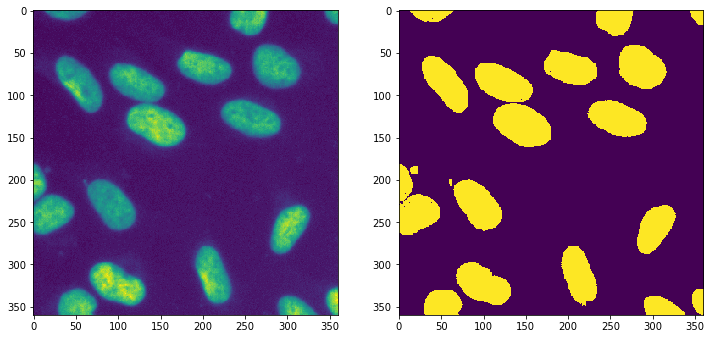

Image #: 227. Image Sizes: (360, 360) (360, 360)


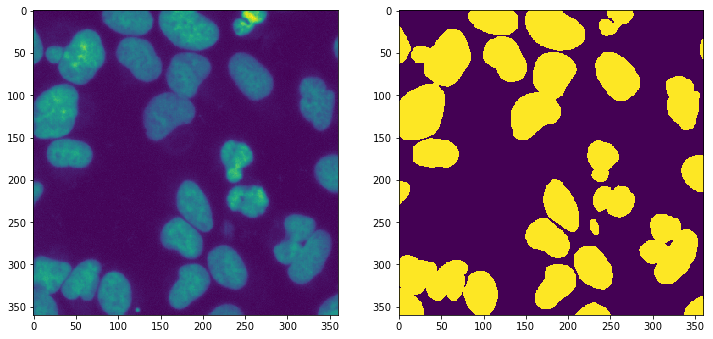

In [65]:
# Plot a training test and mask image side by side
def plot_side_by_side(image_ds,mask_ds,image_num):
    print('Image #: ' + str(image_num) + '. Image Sizes: ' + str(image_ds[image_num].shape) + ' ' + str(mask_ds[image_num].shape))
    fig = plt.figure(figsize=(12,12))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(image_ds[image_num])
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(mask_ds[image_num])
    plt.show()
    
# Plots random corresponding images and masks
def plot_check(images,masks,rand_imgs=None,img_nums=None):
    if rand_imgs != None:
        for i in range(rand_imgs):
            plot_side_by_side(images,masks,randint(0,len(images)-1))
    if img_nums != None:
        for i in range(len(img_nums)):
            plot_side_by_side(images,masks,img_nums[i])
    
#plot_side_by_side(train_images,train_mask_images,38)
# Plot a few random images 
plot_check(train_images,train_mask_images,rand_imgs=3)


In [41]:
# Resize everything

# Scaling
#resized_train_images = [ resize(image,(img_width,img_height),mode='reflect') for image in train_images] 
#resized_train_mask_images = [ resize(image,(img_width,img_height),mode='reflect') for image in train_mask_images] 

#Croping

crop_size=64

resized_train_images = [ image[int(0.5*(image.shape[0]-crop_size)):int(0.5*(image.shape[0]+crop_size)),
   int(0.5*(image.shape[1]-crop_size)):int(0.5*(image.shape[1]+crop_size))] for image in train_images] 

resized_train_mask_images = [ image[int(0.5*(image.shape[0]-crop_size)):int(0.5*(image.shape[0]+crop_size)),
   int(0.5*(image.shape[1]-crop_size)):int(0.5*(image.shape[1]+crop_size))] for image in train_mask_images] 


Image #: 405. Image Sizes: (64, 64) (64, 64)


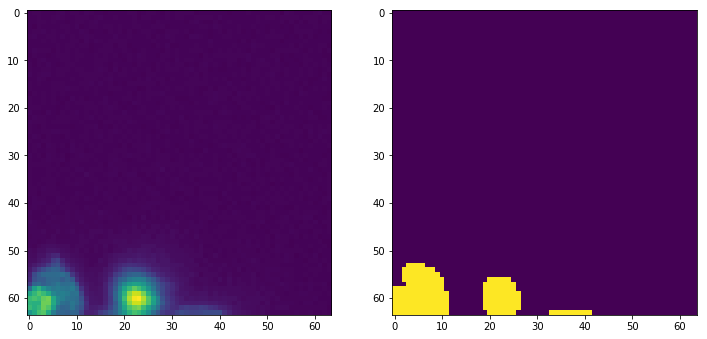

Image #: 300. Image Sizes: (64, 64) (64, 64)


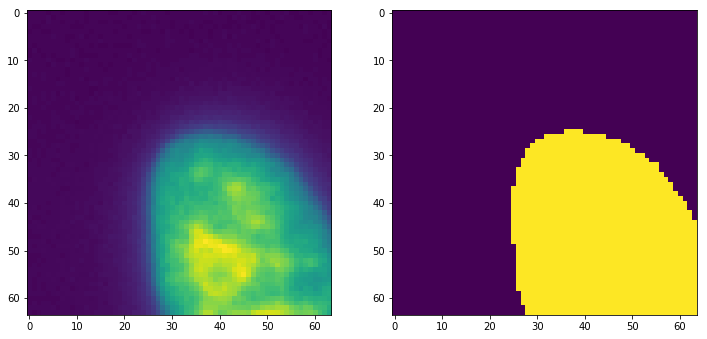

Image #: 542. Image Sizes: (64, 64) (64, 64)


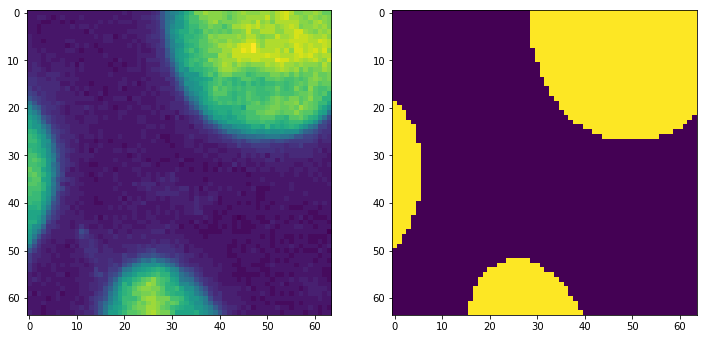

Image #: 339. Image Sizes: (64, 64) (64, 64)


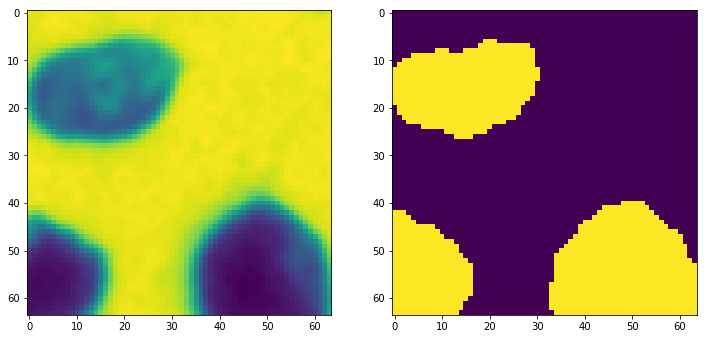

Image #: 143. Image Sizes: (64, 64) (64, 64)


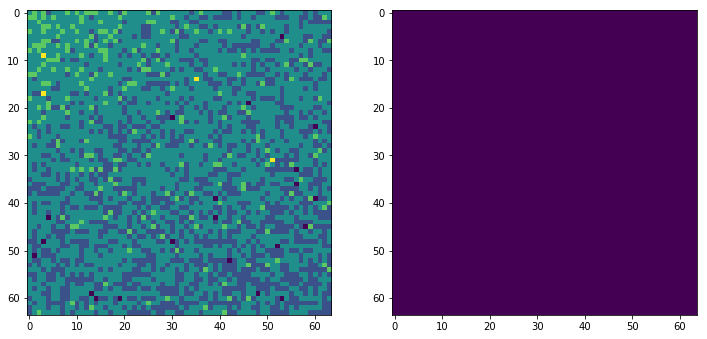

In [66]:
# Plot some resized images
plot_check(resized_train_images,resized_train_mask_images,5)

In [47]:
# Compress dtypes to make computation faster

compressed_train_images = [ (image * (255/image.max())).astype(np.uint8) for image in resized_train_images ]
compressed_train_masks = [ (image /image.max()).astype(bool) for image in resized_train_mask_images ]

C:\Users\jesse\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Image #: 634. Image Sizes: (64, 64) (64, 64)


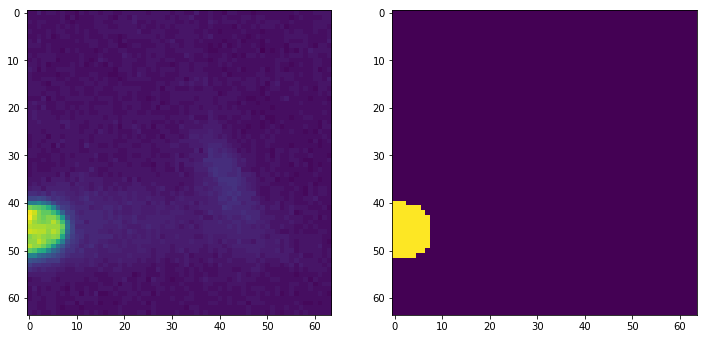

Image #: 128. Image Sizes: (64, 64) (64, 64)


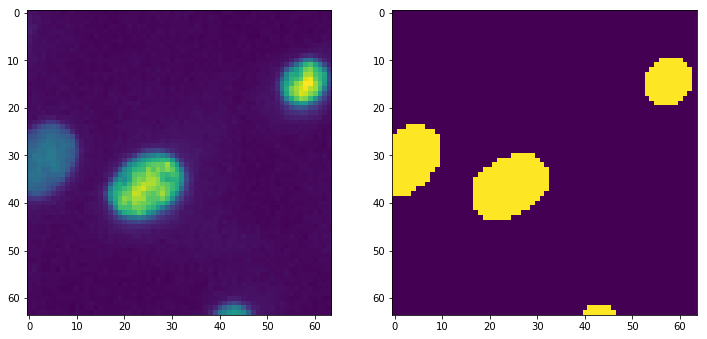

Image #: 127. Image Sizes: (64, 64) (64, 64)


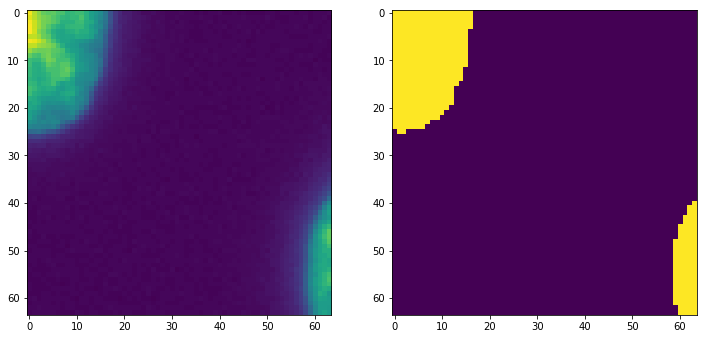

Image #: 633. Image Sizes: (64, 64) (64, 64)


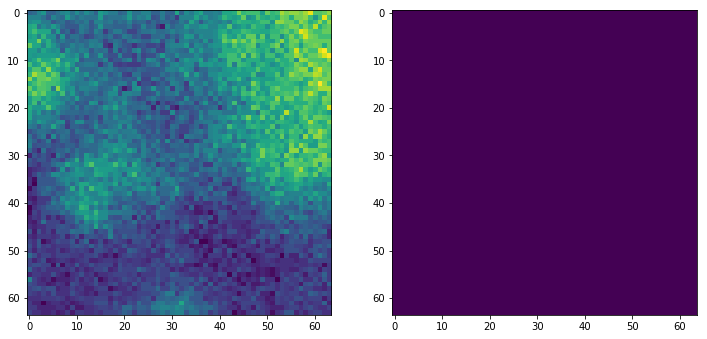

Image #: 458. Image Sizes: (64, 64) (64, 64)


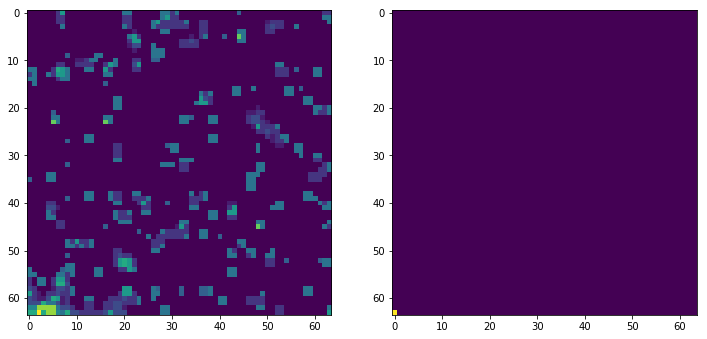

In [67]:
plot_check(compressed_train_images,compressed_train_masks,5)

In [38]:
len(compressed_train_images)

670

In [72]:
# Reshape model inputs
train_X = np.reshape(np.array(compressed_train_images),(len(compressed_train_images),img_height,img_width,1))
train_Y = (np.reshape(np.array(compressed_train_masks),(len(compressed_train_masks),img_height,img_width,1)))

# Check size of arrays we are inputting to model
print(train_X.shape)
print(train_Y.shape)
print(train_X.nbytes)
print(train_Y.nbytes)

(670, 64, 64, 1)
(670, 64, 64, 1)
2744320
2744320


In [71]:
train_Y[0].dtype
#train_X[0]

dtype('bool')

Image #: 5. Image Sizes: (64, 64) (64, 64)


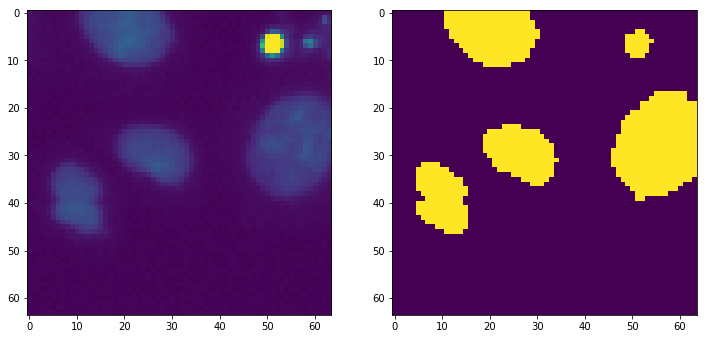

Image #: 119. Image Sizes: (64, 64) (64, 64)


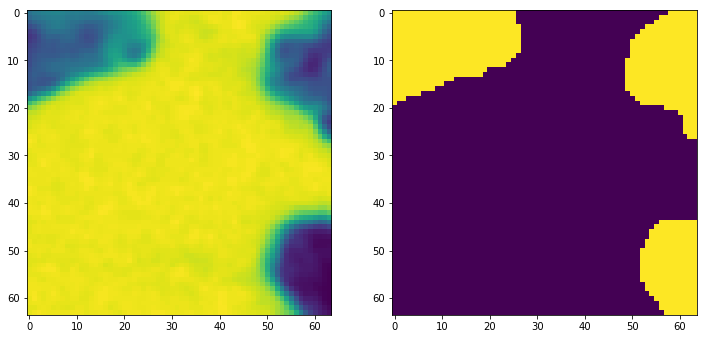

Image #: 356. Image Sizes: (64, 64) (64, 64)


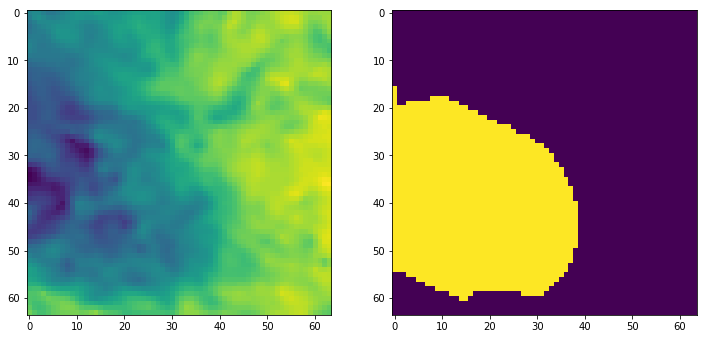

Image #: 602. Image Sizes: (64, 64) (64, 64)


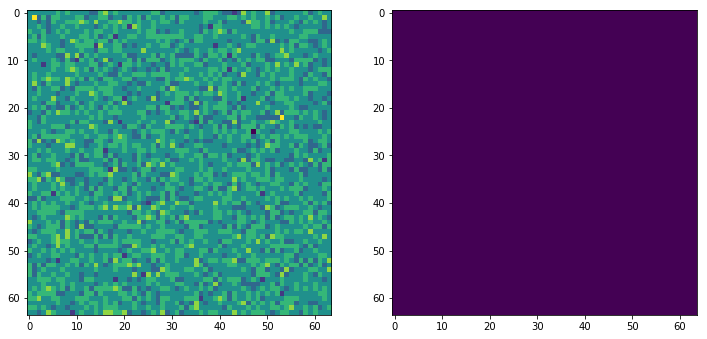

Image #: 5. Image Sizes: (256, 256) (256, 256)


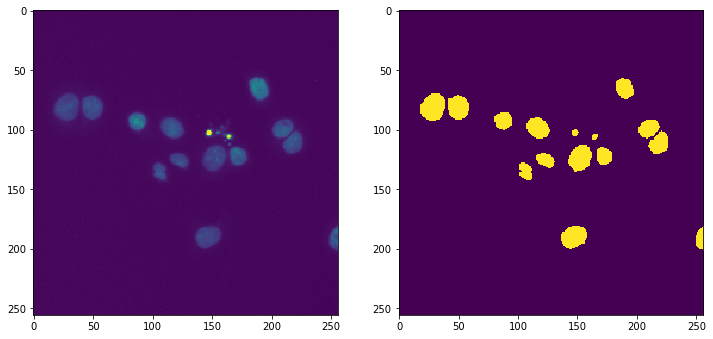

Image #: 119. Image Sizes: (256, 320) (256, 320)


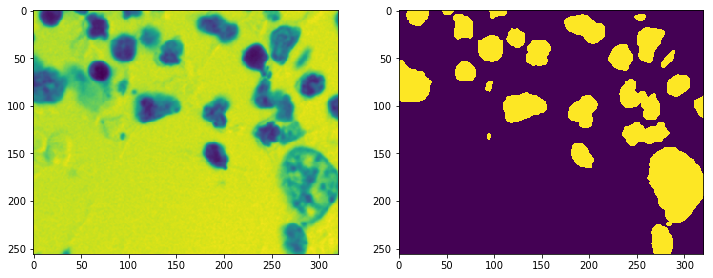

Image #: 356. Image Sizes: (256, 320) (256, 320)


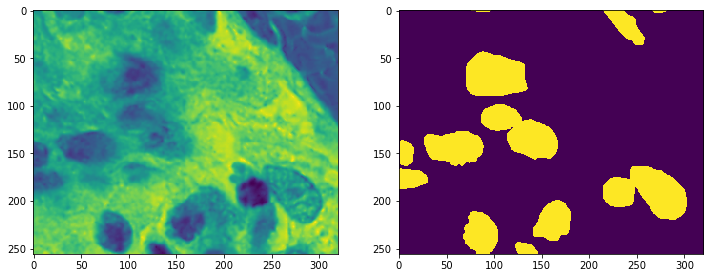

Image #: 602. Image Sizes: (256, 256) (256, 256)


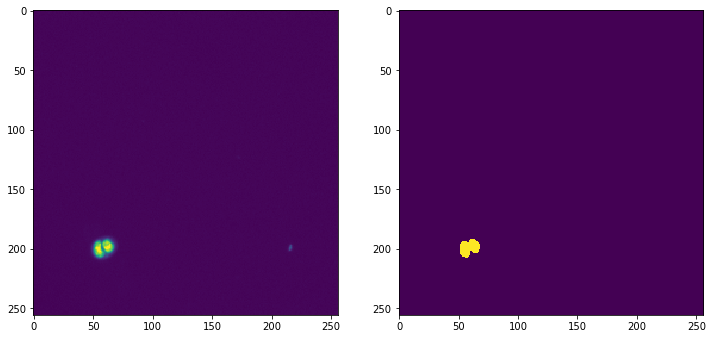

In [73]:
plot_check(np.squeeze(train_X,axis=3),np.squeeze(train_Y,axis=3),img_nums=[5,119,356,602])
plot_check(train_images,train_mask_images,img_nums=[5,119,356,602])

# Now Let's Build the Model

In [122]:
# Loss and metric functions for the neural net
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def create_block(x, filters=30, filter_size=(3, 3), activation='relu',dil_rate=(1,1),dropout_rate=0.05):
#    for i in range(n_block):
    x = Conv2D(filters, filter_size, padding='same', dilation_rate = dil_rate) (x)
    x = Activation('relu') (x)
    x = BatchNormalization() (x) 
    x = Dropout(dropout_rate) (x)
    return x


## master function for creating a net
def get_net(
        input_shape=(img_height, img_width,1),
        lr=0.0001,
        loss=bce_dice_loss,
        n_class=1
):
    inputs = Input(input_shape)
    
    # Create layers
    net_body = create_block(inputs)
    net_body = create_block(net_body)
    net_body = create_block(net_body,dil_rate=(2,2))
    net_body = create_block(net_body,dil_rate=(4,4))
    net_body = create_block(net_body,dil_rate=(8,8))
    net_body = create_block(net_body)
    net_body = create_block(net_body)
    # Sigmoid used since we are classifying pixels 1/0. Softmax used for multiclass
    classify = Conv2D(n_class,(1,1),activation='sigmoid') (net_body)
    
    #classify = Activation(activation='sigmoid') (net_body)
    #classify = Dense(1,activation='sigmoid') (net_body)

    model = Model(inputs=inputs, outputs=classify)
    model.compile(optimizer=Adam(lr), loss=loss, metrics=[dice_coef, binary_crossentropy])

    return model

In [123]:
my_model = get_net()

In [124]:
print(my_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 64, 64, 30)        300       
_________________________________________________________________
activation_95 (Activation)   (None, 64, 64, 30)        0         
_________________________________________________________________
batch_normalization_93 (Batc (None, 64, 64, 30)        120       
_________________________________________________________________
dropout_93 (Dropout)         (None, 64, 64, 30)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 64, 64, 30)        8130      
_________________________________________________________________
activation_96 (Activation)   (None, 64, 64, 30)        0         
__________

In [125]:
# Fit model

# Implement learning rate decay https://keras.io/callbacks/#learningratescheduler 

earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(model_checkpoint_file, verbose=1, save_best_only=True)
reduce_plateau = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.5,
                           patience=2,
                           verbose=1,
                           mode='auto') 
# verbose=2 => one line per epoch, 1 = progress bar
results = my_model.fit(train_X, train_Y, validation_split=0.2, batch_size=17, epochs=50, verbose=1 , shuffle=True,
                    callbacks=[earlystopper, checkpointer, reduce_plateau])

Train on 536 samples, validate on 134 samples
Epoch 1/50
527/536 [============================>.] - ETA: 1s - loss: 1.0691 - dice_coef: 0.6487 - binary_crossentropy: 0.6474
Epoch 00001: val_loss improved from inf to 0.62799, saving model to bw_model_v4.h5
536/536 [==============================] - 122s 228ms/step - loss: 1.0627 - dice_coef: 0.6515 - binary_crossentropy: 0.6440 - val_loss: 0.6280 - val_dice_coef: 0.7826 - val_binary_crossentropy: 0.3300
Epoch 2/50
527/536 [============================>.] - ETA: 1s - loss: 0.8849 - dice_coef: 0.7209 - binary_crossentropy: 0.5448
Epoch 00002: val_loss improved from 0.62799 to 0.54456, saving model to bw_model_v4.h5
536/536 [==============================] - 117s 217ms/step - loss: 0.8992 - dice_coef: 0.7147 - binary_crossentropy: 0.5535 - val_loss: 0.5446 - val_dice_coef: 0.8248 - val_binary_crossentropy: 0.3138
Epoch 3/50
527/536 [============================>.] - ETA: 1s - loss: 0.7949 - dice_coef: 0.7417 - binary_crossentropy: 0.4794
E

Epoch 22/50
527/536 [============================>.] - ETA: 1s - loss: 0.5522 - dice_coef: 0.8035 - binary_crossentropy: 0.3113
Epoch 00022: val_loss improved from 0.35409 to 0.33228, saving model to bw_model_v4.h5
536/536 [==============================] - 113s 210ms/step - loss: 0.5481 - dice_coef: 0.8047 - binary_crossentropy: 0.3089 - val_loss: 0.3323 - val_dice_coef: 0.9003 - val_binary_crossentropy: 0.1929
Epoch 23/50
527/536 [============================>.] - ETA: 1s - loss: 0.5339 - dice_coef: 0.8139 - binary_crossentropy: 0.3029
Epoch 00023: val_loss did not improve
536/536 [==============================] - 111s 208ms/step - loss: 0.5373 - dice_coef: 0.8124 - binary_crossentropy: 0.3050 - val_loss: 0.3377 - val_dice_coef: 0.8978 - val_binary_crossentropy: 0.1959
Epoch 24/50
527/536 [============================>.] - ETA: 1s - loss: 0.5195 - dice_coef: 0.8162 - binary_crossentropy: 0.2937
Epoch 00024: val_loss did not improve
536/536 [==============================] - 112s 209

In [ ]:
Ideas
 - Experiment with compression of training data. Am I preserving as much detail
    as I can in dtype np.uint8 (values of 0 to 255) ?
- Color vs B&W?
- Put computer vision / threshold method output as an input to neural net
- Output intermediate layers for inspection
- Crop images to train networks faster for testing ??
- Take random crops of images to create, and then combine outputs in the end
- Is combining the masks really the best thing to do? Should I be keeping the individual cells separate?
- Pseudo-labelled data